In [48]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import linregress
import seaborn as sns

In [2]:
delta7_Glucl_df= pd.read_csv('/home/tianhaoqiu/Desktop/delta7_Glucl_puncta_count.csv')

In [3]:
delta7_Glucl_df

,ROI num,Left,Right
0,1,6,19
1,2,21,51
2,3,100,76
3,4,13,37
4,5,16,33
5,6,29,20
6,7,35,106
7,8,32,24
8,9,13,56


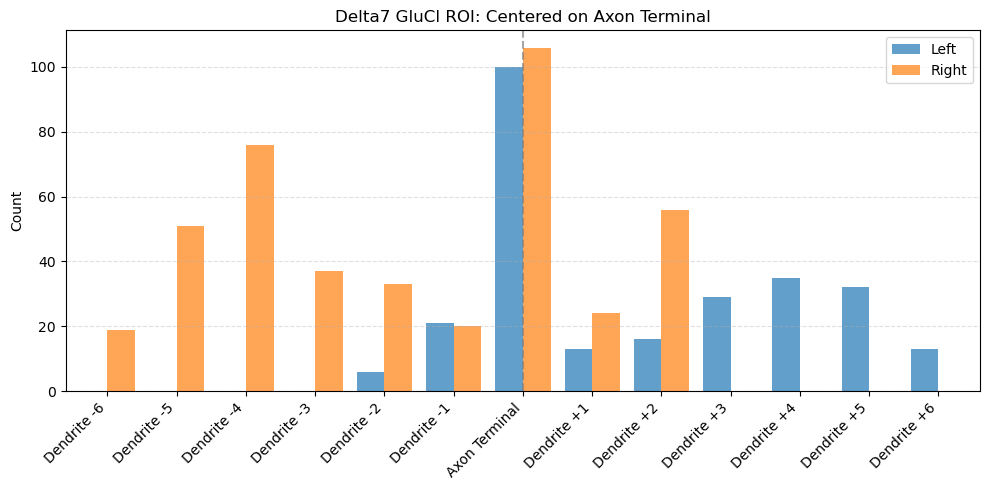

In [21]:
# Step 1: Find the ROI with the maximum in Left and Right
center_left_idx = delta7_Glucl_df['Left'].idxmax()
center_right_idx = delta7_Glucl_df['Right'].idxmax()

center_left_roi = delta7_Glucl_df.loc[center_left_idx, 'ROI num']
center_right_roi = delta7_Glucl_df.loc[center_right_idx, 'ROI num']

# Step 2: Calculate position relative to center
delta7_Glucl_df['Left_pos'] = delta7_Glucl_df['ROI num'] - center_left_roi
delta7_Glucl_df['Right_pos'] = delta7_Glucl_df['ROI num'] - center_right_roi

# Step 3: Create label maps
def label_mapper(pos):
    return 'Axon Terminal' if pos == 0 else f"Dendrite {pos:+d}"

x_labels_left = [label_mapper(p) for p in delta7_Glucl_df['Left_pos']]
x_labels_right = [label_mapper(p) for p in delta7_Glucl_df['Right_pos']]

# Step 4: Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Bar width and shifting
bar_width = 0.4

# X locations
x_left = delta7_Glucl_df['Left_pos']
x_right = delta7_Glucl_df['Right_pos']

# Plot bars
ax.bar(x_left - bar_width/2, delta7_Glucl_df['Left'], width=bar_width, label='Left', alpha=0.7)
ax.bar(x_right + bar_width/2, delta7_Glucl_df['Right'], width=bar_width, label='Right', alpha=0.7)

# X ticks: combine unique positions from both
all_positions = sorted(set(x_left) | set(x_right))
all_labels = [label_mapper(p) for p in all_positions]
ax.set_xticks(all_positions)
ax.set_xticklabels(all_labels, rotation=45, ha='right')

# Aesthetics
ax.set_ylabel("Count")
ax.set_title("Delta7 GluCl ROI: Centered on Axon Terminal")
ax.axvline(0, linestyle='--', color='gray', alpha=0.7)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

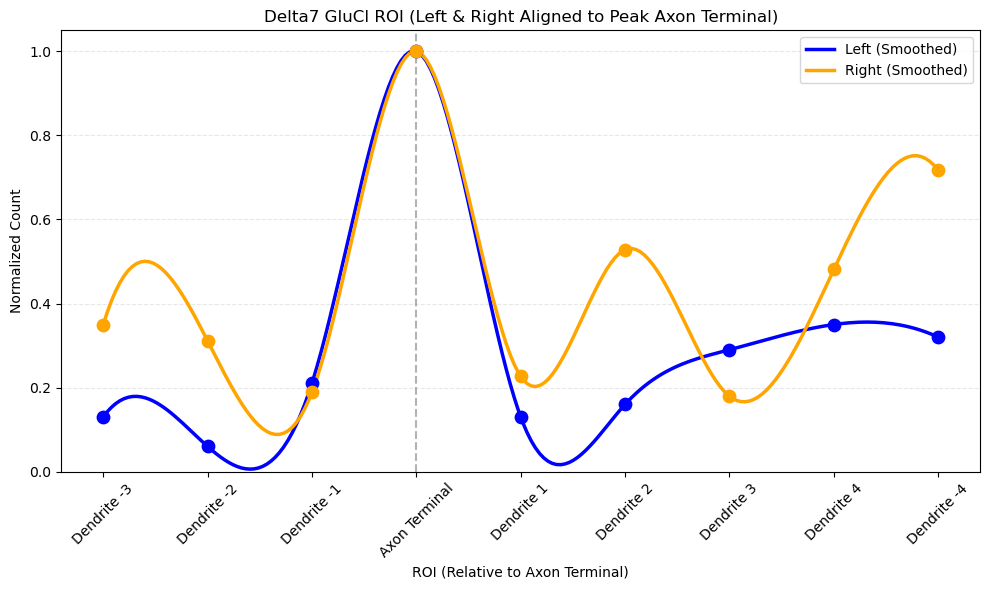

In [23]:

# Shift peak to new center index = 3
new_center_idx = 3

# Find peak index for each side
left_peak_idx = delta7_Glucl_df['Left'].idxmax()
right_peak_idx = delta7_Glucl_df['Right'].idxmax()

# Shift amounts
left_shift = new_center_idx - left_peak_idx
right_shift = new_center_idx - right_peak_idx

# Apply shift and normalize
left_raw = np.roll(delta7_Glucl_df['Left'].values, shift=left_shift)
right_raw = np.roll(delta7_Glucl_df['Right'].values, shift=right_shift)
left_aligned = left_raw / np.max(left_raw)
right_aligned = right_raw / np.max(right_raw)

# Adjust x-axis: from -3 to +5 → we remap to -4 to +4 for labeling
x = np.arange(len(left_aligned)) - new_center_idx
x_labels = [f"Dendrite {i}" if i != 0 else "Axon Terminal" for i in list(x[:-1]) + [-4]]

# Interpolation
x_fine = np.linspace(x.min(), x.max(), 200)
interp_left = interp1d(x, left_aligned, kind='cubic')
interp_right = interp1d(x, right_aligned, kind='cubic')
left_smooth = interp_left(x_fine)
right_smooth = interp_right(x_fine)

# Plotting
plt.figure(figsize=(10, 6))

# Smoothed lines
plt.plot(x_fine, left_smooth, color='blue', linewidth=2.5, label="Left (Smoothed)")
plt.plot(x_fine, right_smooth, color='orange', linewidth=2.5, label="Right (Smoothed)")

# Original points
plt.scatter(x, left_aligned, color='blue', s=80, zorder=5)
plt.scatter(x, right_aligned, color='orange', s=80, zorder=5)

# Mark center
plt.axvline(0, linestyle='--', color='gray', alpha=0.6)

# Labels and formatting
plt.xticks(ticks=x, labels=x_labels, rotation=45)
plt.xlabel("ROI (Relative to Axon Terminal)")
plt.ylabel("Normalized Count")
plt.title("Delta7 GluCl ROI (Left & Right Aligned to Peak Axon Terminal)")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

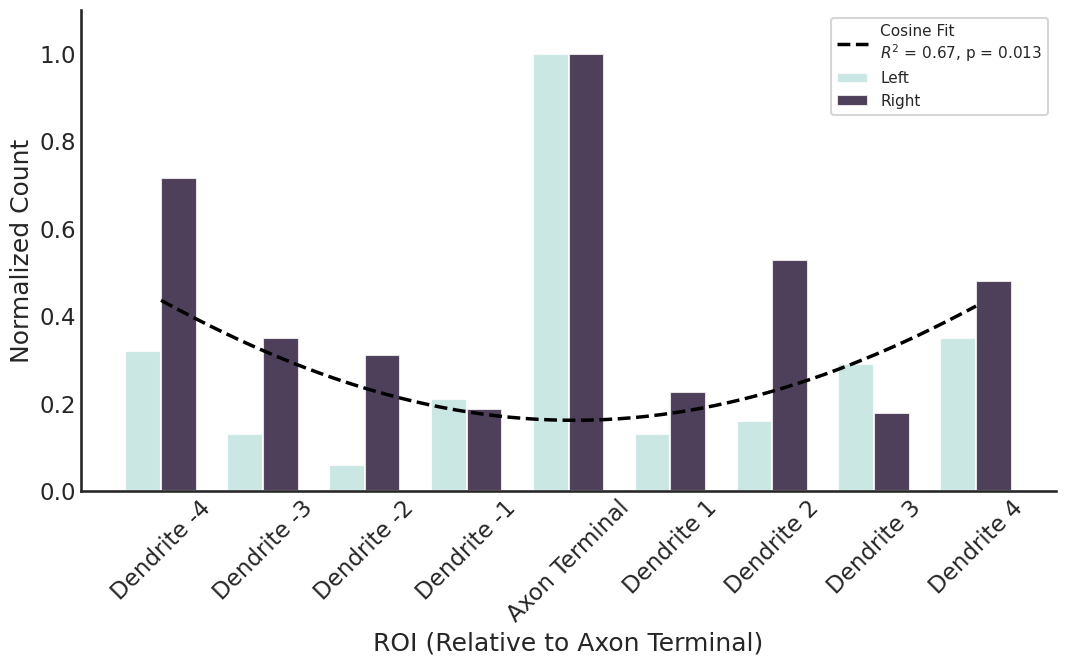

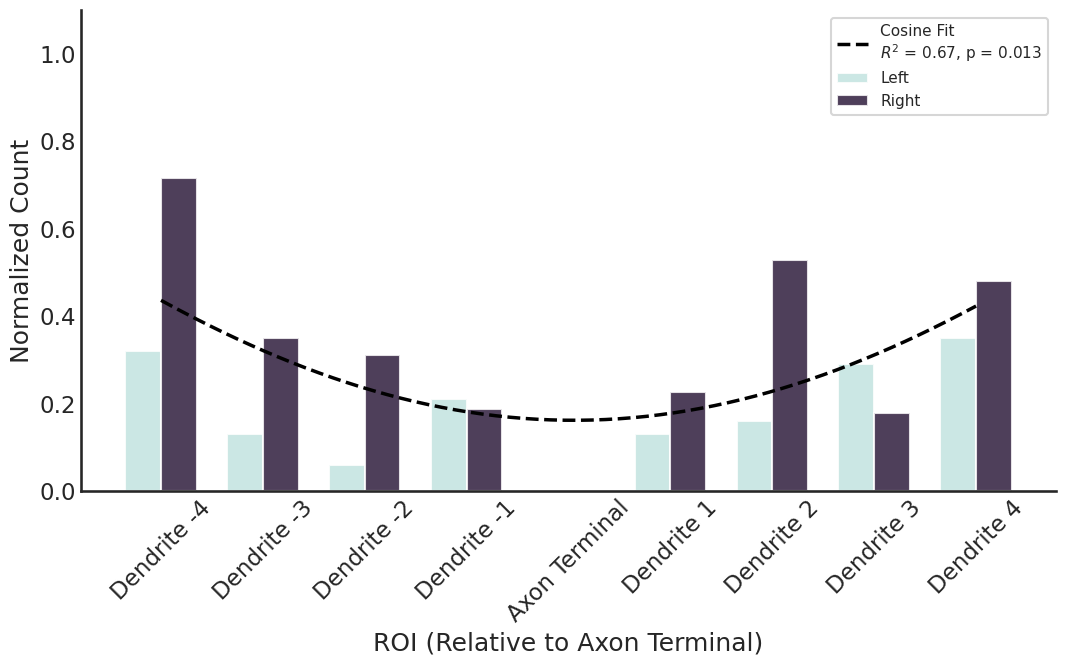

In [70]:
sns.set(style="white", context="talk")

def cosine_func(x, A, B, C, D):
    return A * np.cos(B * x + C) + D

def fit_cosine_and_plot(data, title, axon_zero=False):
    new_center_idx = 4
    left = data['Left'].values
    right = data['Right'].values

    # Align peaks to center
    left_shift = new_center_idx - np.argmax(left)
    right_shift = new_center_idx - np.argmax(right)
    left_aligned = np.roll(left, shift=left_shift)
    right_aligned = np.roll(right, shift=right_shift)

    # Normalize
    left_norm = left_aligned / np.max(left_aligned)
    right_norm = right_aligned / np.max(right_aligned)

    x = np.arange(len(left_norm)) - new_center_idx
    x_labels = [f"Dendrite {i}" if i != 0 else "Axon Terminal" for i in x]

    # Zero axon terminal if requested
    if axon_zero:
        left_norm[new_center_idx] = 0
        right_norm[new_center_idx] = 0

    # Average and fit (excluding axon terminal)
    y_avg = (left_norm + right_norm) / 2
    x_fit = x
    mask = x_fit != 0
    x_fit_fit = x_fit[mask]
    y_fit_fit = y_avg[mask]

    try:
        popt, _ = curve_fit(
            cosine_func, x_fit_fit, y_fit_fit,
            p0=[0.5, 0.5, 0, 0.5],
            bounds=([0, 0, -2*np.pi, 0], [2, 2, 2*np.pi, 1]),
            maxfev=5000
        )
        x_fine = np.linspace(min(x), max(x), 300)
        y_cos_fit = cosine_func(x_fine, *popt)

        y_pred = cosine_func(x_fit_fit, *popt)
        slope, intercept, r_val, p_val, stderr = linregress(y_fit_fit, y_pred)
        r_squared = r_val**2
    except Exception as e:
        y_cos_fit = None
        r_squared = np.nan
        p_val = np.nan
        print("⚠️ Cosine fit failed:", e)

    # Custom palette
    palette = sns.color_palette("ch:s=.40,rot=-.40", n_colors=2)

    # Plotting
    plt.figure(figsize=(11, 7))
    bar_width = 0.35

    plt.bar(x - bar_width / 2, left_norm, width=bar_width, label='Left', color=palette[0], alpha=0.85)
    plt.bar(x + bar_width / 2, right_norm, width=bar_width, label='Right', color=palette[1], alpha=0.85)

    if y_cos_fit is not None:
        plt.plot(x_fine, y_cos_fit, color='black', linestyle='--', linewidth=2.5,
                 label=f'Cosine Fit\n$R^2$ = {r_squared:.2f}, p = {p_val:.3f}')

    plt.xticks(ticks=x, labels=x_labels, rotation=45)
    plt.xlabel("ROI (Relative to Axon Terminal)")
    plt.ylabel("Normalized Count")
    #plt.title(title, fontsize=17)
    plt.ylim(0, 1.1)
    plt.legend(fontsize=11)
    plt.tick_params(axis='both', which='both', length=0)
    sns.despine()
    plt.tight_layout()
    plt.show()


# Final two plots with updated colors
fit_cosine_and_plot(delta7_Glucl_df.copy(), "Delta7 GluCl ROI - Original (Cosine Fit)")
fit_cosine_and_plot(delta7_Glucl_df.copy(), "Delta7 GluCl ROI - Axon Terminal Set to 0", axon_zero=True)



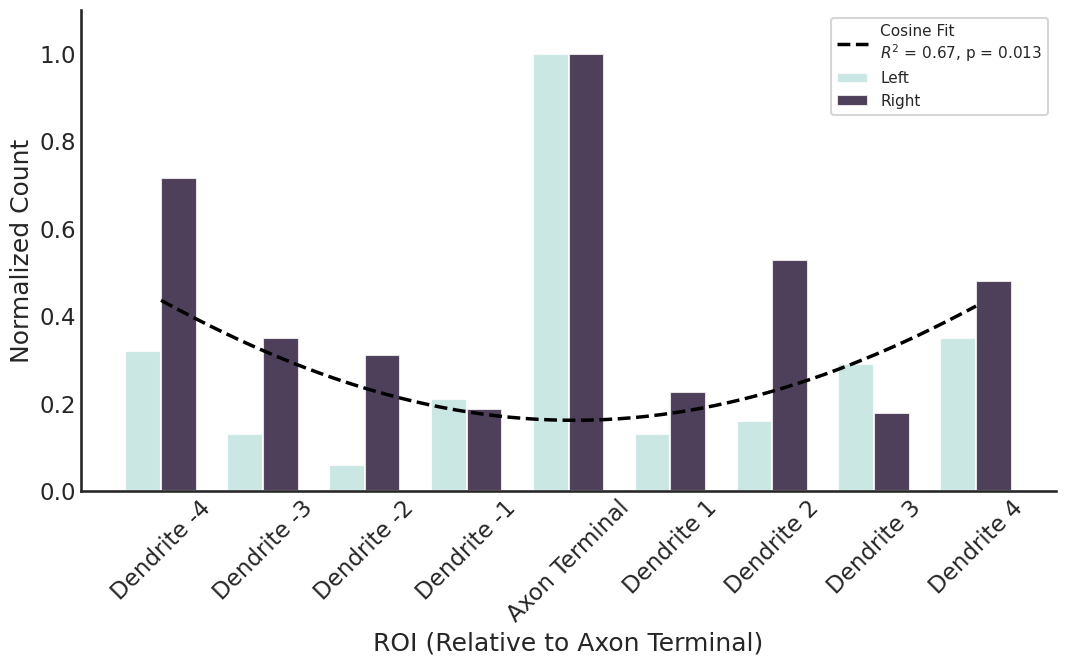

In [71]:
fit_cosine_and_plot(delta7_Glucl_df.copy(), "Delta7 GluCl ROI - Original (Cosine Fit)")